<a href="https://colab.research.google.com/github/vishalsingha/Mnist-Classification/blob/main/Mnist_DataAugmentation_Model_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Kaggle Digit Recognizer Challenge</center>

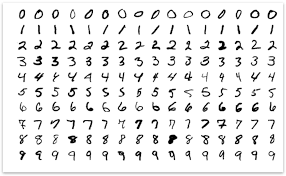</center>

## How to the data from Kaggle 🤔🤔

 ohh!🤯🤯 it's a boring job to upload the data to google colab.
 Well don't get bored here's a solution 


1.   Click on the profile pic of ur Kaggle handle and select the *'My account'*
2.   Scroll down to API and select *'Expire API Token'* and now select the 'Create New API Token'.
3. A jason file will be downloaded. Copy the copy 'KAGGLE_USERNAME' and 'KAGGLE_KEY' and paste in code.
4. Go to the Digit Recognizer Competition copy API token.<br><br>
That all Boom😍😍😍... You have the data inside ur colab.






In [ ]:
#load data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "vishalsingh123"
os.environ['KAGGLE_KEY'] = "1a962bdaec58e6373ed5ea4daf627176"
!kaggle competitions download -c digit-recognizer

401 - Unauthorized


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import library
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import keras 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# load train data
df_train = pd.read_csv('/content/train.csv.zip')
df_train.head()

In [ ]:
Y = df_train['label']
Y_input = to_categorical(Y, num_classes = 10)
data_train = df_train.drop(['label'], axis = 1)
Y_input.shape

In [ ]:
# plot the labels
sns.countplot(x=Y)

In [ ]:
# load test data
df_test = pd.read_csv('/content/test.csv.zip')
df_test.head()

In [ ]:
# scale the data
s = MinMaxScaler()
s.fit(data_train)
data_scaled = s.transform(data_train)
data_input = data_scaled.reshape(42000, 28, 28, 1)
test_data = s.transform(df_test)
test_set = test_data.reshape(-1, 28, 28, 1)

### Create Model
To create a good Model Just First create a base model and than iterate over it to create a final model by addaing the ingridients.

In [ ]:
# create model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, input_shape = (28, 28, 1), kernel_size = (3,3), strides = (1, 1), padding ='same',  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3, 3), padding = 'same', strides =(1, 1), kernel_initializer='he_uniform' ))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.20))
    model.add(Conv2D(128, (3, 3), padding = 'same', strides =(1, 1),kernel_initializer='he_uniform' ))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(250, kernel_initializer='he_uniform'))
    model.add(LeakyReLU(0.1))
    model.add(Dense(100, kernel_initializer='he_uniform'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.20))
    model.add(Dense(10,kernel_initializer='he_uniform', activation = 'sigmoid'))
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adamax')
    return model


### Data Augmentation

 One of the major challanege for neural networks is to get more and more data🙁🙁. Because in Deep learning more data means more accuracy(but not always).  Since here data is less so it will help .

 💡💡Let's create the new data and use data augmentation.

 Here we have to use the parameters for data augmentation by being specific about our problem. For example we can't flip the digits horozonatally as 6 and 9 will interchange and some useless symblols will be formed. So here slight rotation, zooming, width_shift and height shift is used. 

In [ ]:
# create generator for augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)


### Model Stacking
 The core idea is to use a group of 16 such CNN models to find the final prediction. First we load the individual model and predict it than after we average the result of all models to get the final output. Here one the the major problem is the time to train the model. So to overcome that we can use better GPUs😲😲.......... which may not available to all. So use the hack!!!... We can train the model and at the same time save it in ur google drive so that we can retrieve it again.





In [ ]:
# train and save model
nets = 16
models = []
History = []
for i in range(nets):
    model = create_model()
    x_train, x_val, y_train, y_val = train_test_split(data_input, Y_input, test_size = 0.1)
    history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=64),
        epochs = 132, steps_per_epoch = x_train.shape[0]//64,  
        validation_data = (x_val,y_val))
    models.append(model)
    model.save(f'/content/drive/My Drive/prgramming/c/m{i}.h5')
    History.append(history)

### Load and predict the models



In [ ]:
# predict the model
models = glob.glob('/content/drive/My Drive/prgramming/c/*')
result = 0
for i in models:
  m = tf.keras.models.load_model(i)
  m_pred = np.argmax(m.predict(test_set), axis = 1)
  m_pred_cat = to_categorical(m_pred, num_classes = 10)
  result = result + m_pred_cat
y_pred = np.argmax(result, axis = 1)

### Save the output of our model in the forrmat required

In [ ]:
df_output = pd.DataFrame()
df_output['ImageId'] = list(range(1, 28001))
df_output['Label'] = y_pred
df_output.to_csv('output.csv', index = False)

### Now it all done. Just download the file and upload the  solution to ur handle to get the rank. 

#### Ohh!!! Let me do first it's a competition 😅😅

### So my result is here
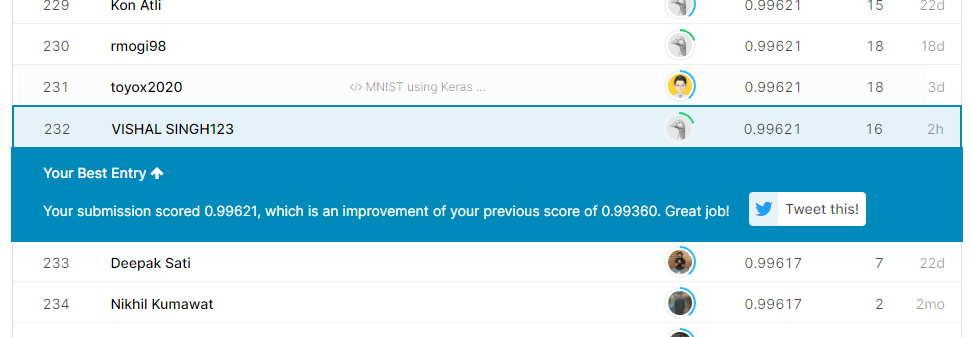